#### Nojus Satikauskas C00261186

# Support Vector Machines (SVMs) for Classification

## Introduction to Support Vector Machines (SVMs)
Support vector machines (SVMs) are powerful and flexible supervised algorithms for classification problems.


Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this chapter, we will explore the intuition behind SVMs and their use in classification problems.

We begin with the standard imports:

In [96]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn
sns.set_style('whitegrid')  # Set seaborn style to whitegrid

# Now you can proceed with your plotting code


## Motivating Support Vector Machines

As part of our discussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned about a simple kind of model that describes the distribution of each underlying class, and experimented with using it to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*. That is, rather than modeling each class, we will simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task in which the two classes of points are well separated (see the following figure):

### ChangeLog:
I change the sample size below to 250 and center amount to 5 which resulted in one of the grouping being far away from the other groups. As I noticed before they tend to not overlap, which is a factor that continued with the 5 centers but when the center count is changed to 4 all 4 grouping stay close together without blop overlap which I found as an interesting difference.

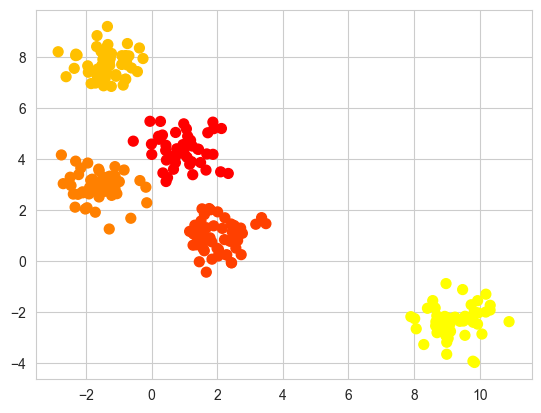

In [121]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=250, centers=5, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two-dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw some of them as follows; the following figure shows the result:

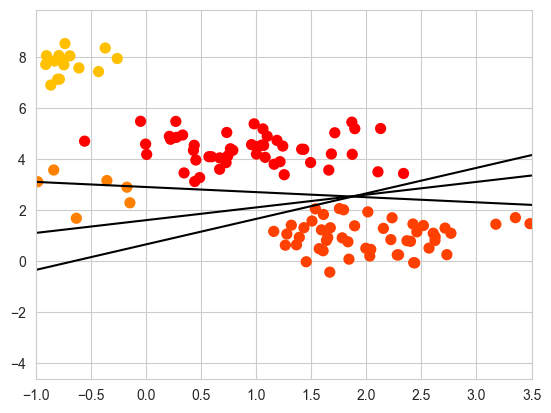

In [123]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.

# Support Vector Machines: Maximizing the Margin
SVMs maximize the margin around the decision boundary to ensure robust classification performance, especially in high-dimensional feature spaces.


## Fitting a Support Vector Machine
Explanation of training an SVM model for face recognition using Scikit-Learn's `SVC` with an RBF kernel.
Visualizing the decision boundary and support vectors.

In [99]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

## Exploring the Dataset

In [100]:
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


## Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [101]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


## Visualising the Data

Let's plot a few of these faces to see what we're working with (see the following figure):

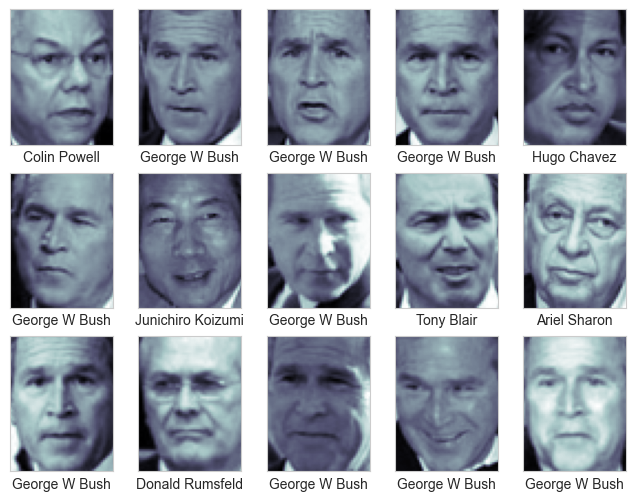

In [102]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains 62 × 47, or around 3,000, pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

## Preprocessing

In [103]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training set and a testing set:

In [104]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

## Model building

In [105]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 3min 16s
Wall time: 31.9 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:

## Evaluating the Model

In [106]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values (see the following figure):

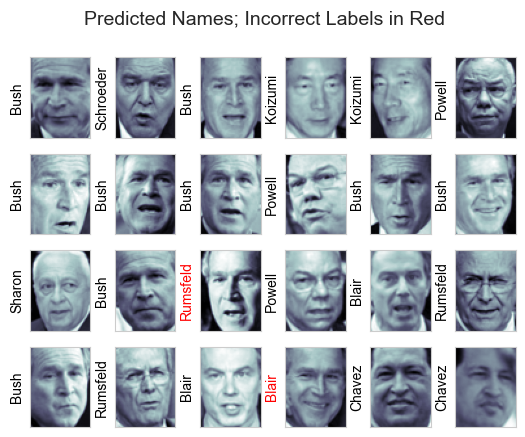

In [107]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [108]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes (see the following figure):

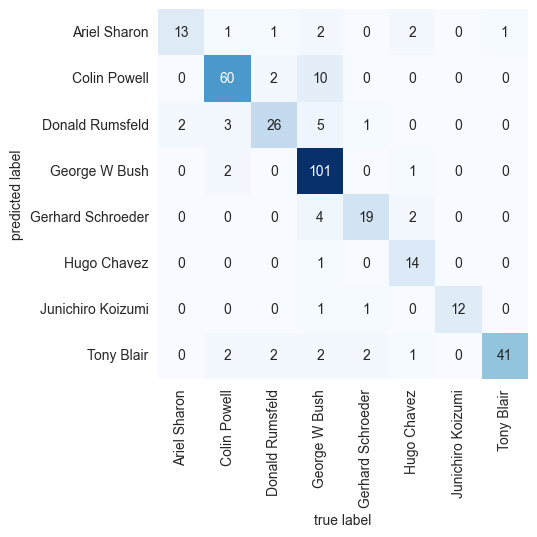

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pretrained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Applying Support Vector Machines to a new dataset

The new dataset I used to make this model was (https://www.kaggle.com/datasets/chetankv/dogs-cats-images) which was cats and dogs to test weather or not the model could identify either after being given a training set 

In [110]:
import cv2
import os

def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

cats_folder = "dataset/training_set/cats"
dogs_folder = "dataset/training_set/dogs"

cat_images = read_images_from_folder(cats_folder)
dog_images = read_images_from_folder(dogs_folder)

print("Number of cat images:", len(cat_images))
print("Number of dog images:", len(dog_images))


Number of cat images: 4000
Number of dog images: 4000


In [111]:
import cv2
import os

def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

cats_test_folder = "dataset/test_set/cats"
dogs_test_folder = "dataset/test_set/dogs"

cat_test_images = read_images_from_folder(cats_test_folder)
dog_test_images = read_images_from_folder(dogs_test_folder)

print("Number of cat test images:", len(cat_test_images))
print("Number of dog test images:", len(dog_test_images))


Number of cat test images: 1000
Number of dog test images: 1000


In [112]:
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset containing cats and dogs images
def load_images(folder_path, target_size=(62, 47)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith('.jpg'):
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, target_size)  # Resize the image to a fixed size
            images.append(img_resized)
            labels.append(0 if 'cat' in filename else 1)  # Assign label 0 for cats and 1 for dogs
    return np.array(images), np.array(labels)

# Load the training dataset
X_train_cats, y_train_cats = load_images('dataset/training_set/cats')
X_train_dogs, y_train_dogs = load_images('dataset/training_set/dogs')

# Concatenate the cats and dogs images and labels
X_train = np.concatenate((X_train_cats, X_train_dogs), axis=0)
y_train = np.concatenate((y_train_cats, y_train_dogs), axis=0)

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42)

# Create a pipeline with PCA and SVM
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca, svc)

# Define the parameter grid for GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

# Perform grid search to find the best model
grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid.best_params_)

# Get the best estimator
best_model = grid.best_estimator_

# Save the trained model to a file
model_filename = "svm_cats_dogs_model.pkl"
joblib.dump(best_model, model_filename)

# Now you can load the saved model and test it on the test set
# Load the trained SVM model
if os.path.exists(model_filename):
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully.")
else:
    print(f"Model file {model_filename} not found.")

# Now you can proceed to test the loaded model on your test data
# For example:
y_pred = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best parameters found by GridSearchCV:
{'svc__C': 5, 'svc__gamma': 0.005}
Model loaded successfully.
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1002
           1       0.63      0.61      0.62       998

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

[[653 349]
 [393 605]]


## Demo of results with images

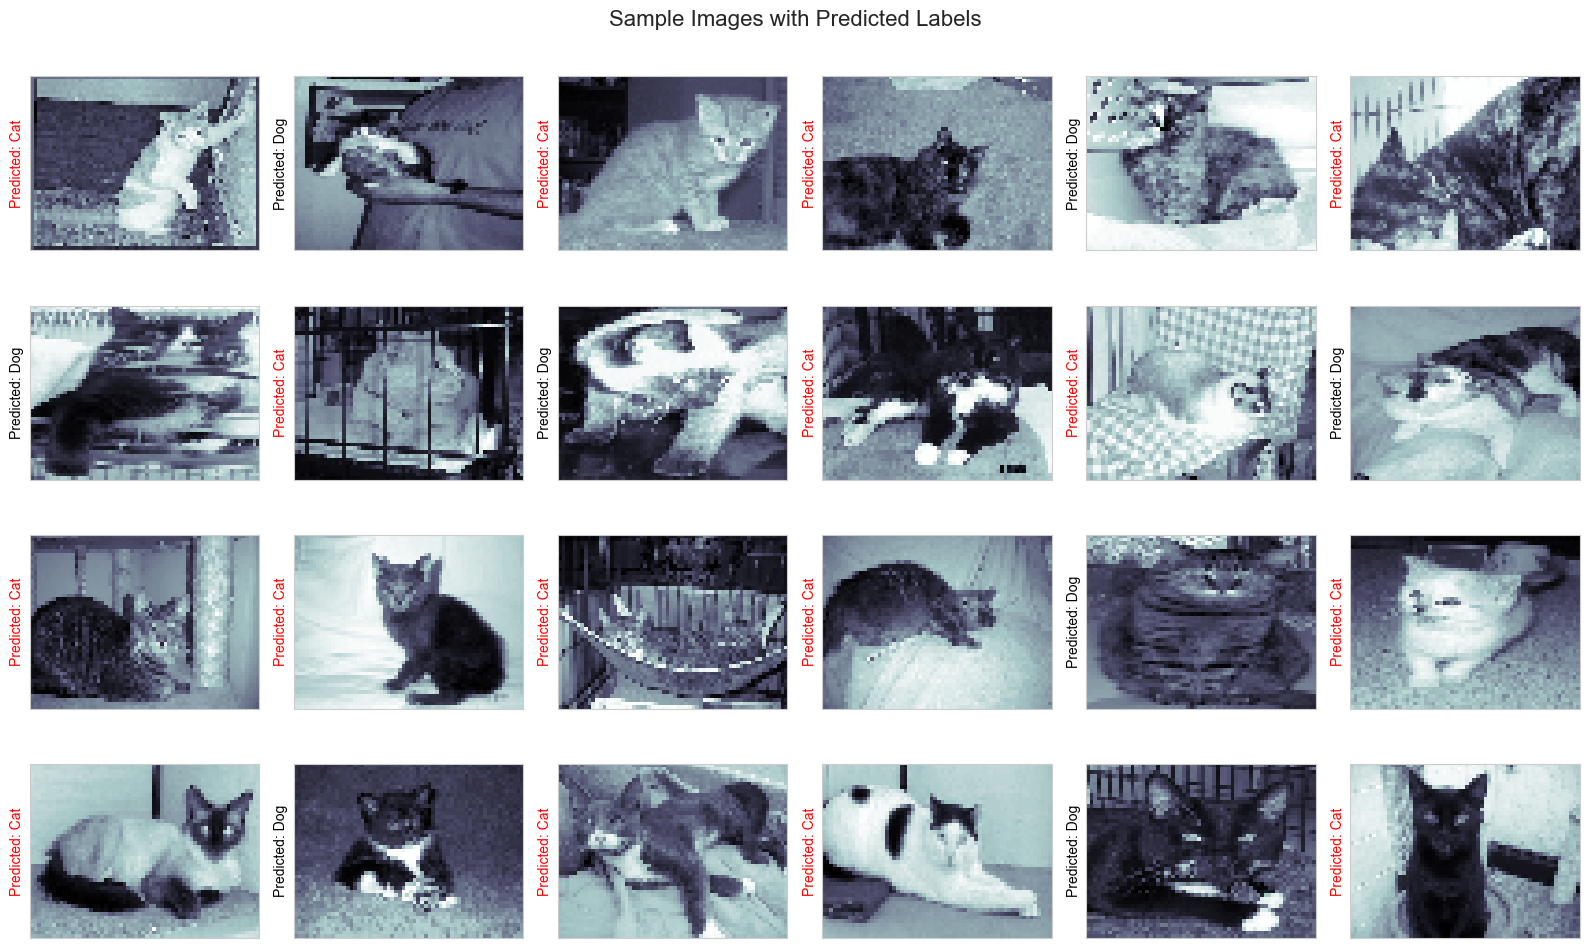

In [113]:
import os
import cv2

# Function to load images from a folder
def load_images_from_folder(folder_path, target_size=(62, 47)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith('.jpg'):
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, target_size)
            images.append(img_resized)
    return images

# Load cat images from the folder
cat_images = load_images_from_folder('dataset/test_set/cats')

# Load dog images from the folder
dog_images = load_images_from_folder('dataset/test_set/dogs')

# Concatenate cat and dog images
all_images = cat_images + dog_images

# Convert to numpy array
X_sample = np.array(all_images)

# Predict labels for the sample data
y_pred_sample = loaded_model.predict(X_sample.reshape(X_sample.shape[0], -1))

# Plot the sample images with their predicted labels
fig, ax = plt.subplots(4, 6, figsize=(16, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_sample[i], cmap='bone', interpolation='nearest')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel('Predicted: {}'.format('Dog' if y_pred_sample[i] == 1 else 'Cat'),
                   color='black' if y_pred_sample[i] == 1 else 'red')
plt.suptitle('Sample Images with Predicted Labels', size=16)
plt.tight_layout()
plt.show()


## Confusion Matrix representing the accuracy of the model

Model loaded successfully.


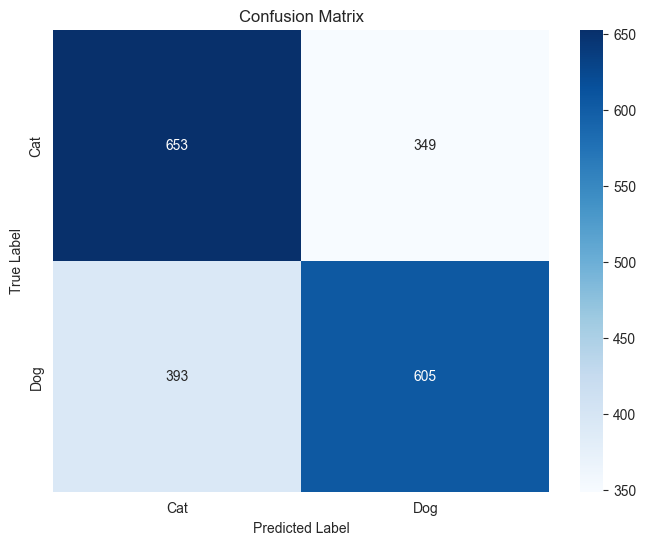

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the trained SVM model
if os.path.exists(model_filename):
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully.")
else:
    print(f"Model file {model_filename} not found.")

# Predict labels for the test data
y_pred = loaded_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Conclusion:
Following the face recognition software, my attempt at using Support Vector Machines on a new dataset resulted in an above average accuracy of 63%, macro-avg 63%, weighted-avg 63%.
There are more improvements I could implement such as experimenting with the model to be trained with different training sets and sample sizes. 

## Summary

This has been a brief intuitive introduction to the principles behind support vector machines.
These models are a powerful classification method, for a number of reasons:

- Their dependence on relatively few support vectors means that they are compact and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter `C`. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the `probability` parameter of `SVC`), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.